# Boundary Element Method for Acoustic Scattering

## Introduction

The **Boundary Element Method (BEM)** is a powerful numerical technique for solving partial differential equations that have been reformulated as boundary integral equations. Unlike the Finite Element Method (FEM), which discretizes the entire domain, BEM only requires discretization of the boundary, reducing the problem dimensionality by one. This makes BEM particularly advantageous for:

1. **Exterior problems** (unbounded domains)
2. **Problems with infinite domains** (acoustic radiation/scattering)
3. **Linear, homogeneous problems** governed by Green's functions

## The Helmholtz Equation

Acoustic wave propagation in a homogeneous medium is governed by the **Helmholtz equation**:

$$\nabla^2 p(\mathbf{r}) + k^2 p(\mathbf{r}) = 0$$

where:
- $p(\mathbf{r})$ is the acoustic pressure field
- $k = \omega/c$ is the wavenumber
- $\omega$ is the angular frequency
- $c$ is the speed of sound

## Green's Function for the Helmholtz Equation

The fundamental solution (Green's function) for the 2D Helmholtz equation is:

$$G(\mathbf{r}, \mathbf{r}') = \frac{i}{4} H_0^{(1)}(k|\mathbf{r} - \mathbf{r}'|)$$

where $H_0^{(1)}$ is the Hankel function of the first kind of order zero, representing outgoing waves (satisfying the **Sommerfeld radiation condition**).

## Boundary Integral Equation

Using Green's second identity, the Helmholtz equation can be transformed into the **Kirchhoff-Helmholtz integral equation**:

$$c(\mathbf{r}) p(\mathbf{r}) = p_{inc}(\mathbf{r}) + \int_{\Gamma} \left[ G(\mathbf{r}, \mathbf{r}') \frac{\partial p}{\partial n}(\mathbf{r}') - p(\mathbf{r}') \frac{\partial G}{\partial n'}(\mathbf{r}, \mathbf{r}') \right] d\Gamma(\mathbf{r}')$$

where:
- $c(\mathbf{r})$ is the solid angle coefficient ($c = 1/2$ for smooth boundaries)
- $p_{inc}$ is the incident field
- $\Gamma$ is the boundary
- $\partial/\partial n$ denotes the normal derivative

## Boundary Conditions

For a **sound-hard (rigid) scatterer**, the Neumann boundary condition applies:

$$\frac{\partial p}{\partial n} = 0 \quad \text{on } \Gamma$$

This simplifies the integral equation to:

$$\frac{1}{2} p(\mathbf{r}) = p_{inc}(\mathbf{r}) - \int_{\Gamma} p(\mathbf{r}') \frac{\partial G}{\partial n'}(\mathbf{r}, \mathbf{r}') d\Gamma(\mathbf{r}')$$

## Normal Derivative of Green's Function

The normal derivative of the 2D Green's function is:

$$\frac{\partial G}{\partial n'}(\mathbf{r}, \mathbf{r}') = -\frac{ik}{4} H_1^{(1)}(k|\mathbf{r} - \mathbf{r}'|) \frac{(\mathbf{r} - \mathbf{r}') \cdot \mathbf{n}'}{|\mathbf{r} - \mathbf{r}'|}$$

where $H_1^{(1)}$ is the Hankel function of the first kind of order one.

## Numerical Discretization

The boundary is discretized into $N$ elements. Using collocation with constant elements, the integral equation becomes a linear system:

$$\frac{1}{2} p_i + \sum_{j=1}^{N} H_{ij} p_j = p_{inc,i}$$

or in matrix form:

$$\mathbf{A} \mathbf{p} = \mathbf{p}_{inc}$$

where $A_{ij} = \frac{1}{2}\delta_{ij} + H_{ij}$ and $H_{ij}$ is the integral of the double-layer kernel over element $j$ evaluated at collocation point $i$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hankel1
from scipy.integrate import quad

# Set up high-quality plotting
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

## Implementation: Acoustic Scattering from a Circular Cylinder

We will compute the scattered field from a **sound-hard circular cylinder** subjected to a plane wave incident field:

$$p_{inc}(\mathbf{r}) = e^{ik\mathbf{d} \cdot \mathbf{r}}$$

where $\mathbf{d}$ is the direction of propagation.

In [2]:
class BEMAcoustics2D:
    """
    Boundary Element Method solver for 2D acoustic scattering
    from a sound-hard (rigid) obstacle.
    """
    
    def __init__(self, k, boundary_points, normals):
        """
        Initialize the BEM solver.
        
        Parameters:
        -----------
        k : float
            Wavenumber
        boundary_points : ndarray (N, 2)
            Collocation points on the boundary
        normals : ndarray (N, 2)
            Outward unit normal vectors at each point
        """
        self.k = k
        self.boundary_points = boundary_points
        self.normals = normals
        self.N = len(boundary_points)
        
        # Compute element lengths (arc length between consecutive points)
        shifted = np.roll(boundary_points, -1, axis=0)
        self.ds = np.linalg.norm(shifted - boundary_points, axis=1)
        
    def green_function(self, r, r_prime):
        """
        2D Helmholtz Green's function: G(r, r') = (i/4) * H_0^(1)(k|r-r'|)
        """
        dist = np.linalg.norm(r - r_prime)
        if dist < 1e-12:
            return 0.0  # Self-term handled separately
        return 0.25j * hankel1(0, self.k * dist)
    
    def green_function_normal_derivative(self, r, r_prime, n_prime):
        """
        Normal derivative of Green's function:
        dG/dn' = -(ik/4) * H_1^(1)(k|r-r'|) * (r-r')·n' / |r-r'|
        """
        diff = r - r_prime
        dist = np.linalg.norm(diff)
        if dist < 1e-12:
            return 0.0  # Self-term handled separately
        
        cos_theta = np.dot(diff, n_prime) / dist
        return -0.25j * self.k * hankel1(1, self.k * dist) * cos_theta
    
    def assemble_system_matrix(self):
        """
        Assemble the BEM system matrix for the sound-hard scattering problem.
        Using collocation method with constant elements.
        
        The system is: (1/2 I + H) p = p_inc
        where H_ij = integral of dG/dn' over element j
        """
        A = np.zeros((self.N, self.N), dtype=complex)
        
        for i in range(self.N):
            r_i = self.boundary_points[i]
            
            for j in range(self.N):
                r_j = self.boundary_points[j]
                n_j = self.normals[j]
                
                if i == j:
                    # Diagonal term: 1/2 + self-integral
                    # For smooth boundary, the principal value integral of dG/dn' gives -1/2
                    # So the diagonal is 1/2 + (-1/2)*ds ≈ 1/2 for small elements
                    # More accurate: use analytical integration for self-term
                    A[i, j] = 0.5
                else:
                    # Off-diagonal: numerical integration over element j
                    # Using midpoint rule for simplicity (constant elements)
                    A[i, j] = self.green_function_normal_derivative(r_i, r_j, n_j) * self.ds[j]
        
        return A
    
    def incident_field(self, r, direction):
        """
        Plane wave incident field: p_inc = exp(i k d·r)
        """
        return np.exp(1j * self.k * np.dot(direction, r))
    
    def solve(self, incident_direction):
        """
        Solve the BEM system for the surface pressure.
        
        Parameters:
        -----------
        incident_direction : ndarray (2,)
            Unit vector giving direction of incident plane wave
            
        Returns:
        --------
        p_surface : ndarray (N,)
            Total pressure on the boundary
        """
        # Assemble system matrix
        A = self.assemble_system_matrix()
        
        # Compute incident field at boundary points
        p_inc = np.array([self.incident_field(r, incident_direction) 
                         for r in self.boundary_points])
        
        # Solve the linear system
        p_surface = np.linalg.solve(A, p_inc)
        
        return p_surface
    
    def compute_scattered_field(self, p_surface, eval_points):
        """
        Compute the scattered field at evaluation points using the
        boundary integral representation.
        
        For sound-hard scattering:
        p_scat(r) = -integral_Gamma p(r') dG/dn'(r,r') dGamma
        """
        p_scat = np.zeros(len(eval_points), dtype=complex)
        
        for i, r in enumerate(eval_points):
            for j in range(self.N):
                r_j = self.boundary_points[j]
                n_j = self.normals[j]
                dGdn = self.green_function_normal_derivative(r, r_j, n_j)
                p_scat[i] -= p_surface[j] * dGdn * self.ds[j]
        
        return p_scat
    
    def compute_total_field(self, p_surface, eval_points, incident_direction):
        """
        Compute total field: p_total = p_inc + p_scat
        """
        p_inc = np.array([self.incident_field(r, incident_direction) 
                         for r in eval_points])
        p_scat = self.compute_scattered_field(p_surface, eval_points)
        return p_inc + p_scat

## Setting Up the Problem: Circular Cylinder

In [3]:
def create_circular_boundary(radius, N):
    """
    Create boundary points and normals for a circular cylinder.
    Points are ordered counterclockwise, normals point outward.
    """
    theta = np.linspace(0, 2*np.pi, N, endpoint=False)
    
    # Boundary points
    points = np.column_stack([radius * np.cos(theta), 
                               radius * np.sin(theta)])
    
    # Outward normal vectors
    normals = np.column_stack([np.cos(theta), np.sin(theta)])
    
    return points, normals

# Problem parameters
radius = 1.0          # Cylinder radius
frequency = 500       # Hz
c = 343.0             # Speed of sound in air (m/s)
k = 2 * np.pi * frequency / c  # Wavenumber

# Dimensionless wavenumber (ka)
ka = k * radius
print(f"Frequency: {frequency} Hz")
print(f"Wavenumber k: {k:.4f} rad/m")
print(f"Wavelength λ: {2*np.pi/k:.4f} m")
print(f"Dimensionless wavenumber ka: {ka:.4f}")

# Number of boundary elements (rule of thumb: ~10 elements per wavelength)
circumference = 2 * np.pi * radius
wavelength = 2 * np.pi / k
N_elements = max(int(10 * circumference / wavelength), 40)
print(f"Number of boundary elements: {N_elements}")

# Create boundary
boundary_points, normals = create_circular_boundary(radius, N_elements)

# Incident wave direction (propagating in +x direction)
incident_direction = np.array([1.0, 0.0])

Frequency: 500 Hz
Wavenumber k: 9.1592 rad/m
Wavelength λ: 0.6860 m
Dimensionless wavenumber ka: 9.1592
Number of boundary elements: 91


## Solving the BEM System

In [4]:
# Create BEM solver
bem = BEMAcoustics2D(k, boundary_points, normals)

# Solve for surface pressure
print("Solving BEM system...")
p_surface = bem.solve(incident_direction)
print("Solution complete!")

# Analyze surface pressure
theta = np.linspace(0, 2*np.pi, N_elements, endpoint=False)
print(f"\nSurface pressure statistics:")
print(f"  Max |p|: {np.max(np.abs(p_surface)):.4f}")
print(f"  Min |p|: {np.min(np.abs(p_surface)):.4f}")
print(f"  Mean |p|: {np.mean(np.abs(p_surface)):.4f}")

Solving BEM system...
Solution complete!

Surface pressure statistics:
  Max |p|: 1.9948
  Min |p|: 0.0855
  Mean |p|: 1.2364


## Computing the Field in the Domain

In [5]:
# Create evaluation grid (exterior domain only)
nx, ny = 100, 100
x = np.linspace(-4*radius, 4*radius, nx)
y = np.linspace(-4*radius, 4*radius, ny)
X, Y = np.meshgrid(x, y)

# Flatten grid for evaluation
eval_points = np.column_stack([X.ravel(), Y.ravel()])

# Mask points inside the cylinder (plus small buffer)
distances = np.sqrt(eval_points[:, 0]**2 + eval_points[:, 1]**2)
exterior_mask = distances > radius * 1.05

# Only compute field at exterior points
exterior_points = eval_points[exterior_mask]

print(f"Computing field at {len(exterior_points)} exterior points...")

# Compute total field
p_total_exterior = bem.compute_total_field(p_surface, exterior_points, incident_direction)

# Reconstruct full field (NaN inside cylinder)
p_total_flat = np.full(len(eval_points), np.nan, dtype=complex)
p_total_flat[exterior_mask] = p_total_exterior
p_total = p_total_flat.reshape(ny, nx)

print("Field computation complete!")

Computing field at 9460 exterior points...


Field computation complete!


## Analytical Solution for Verification

For a circular cylinder, an analytical solution exists using separation of variables:

$$p_{scat}(r, \theta) = -\sum_{n=0}^{\infty} \epsilon_n i^n \frac{J_n'(ka)}{H_n^{(1)'}(ka)} H_n^{(1)}(kr) \cos(n\theta)$$

where $\epsilon_0 = 1$, $\epsilon_n = 2$ for $n \geq 1$.

In [6]:
from scipy.special import jv, jvp, h1vp

def analytical_scattered_field(r, theta, k, a, n_terms=30):
    """
    Analytical solution for plane wave scattering from a sound-hard cylinder.
    """
    ka = k * a
    kr = k * r
    
    p_scat = np.zeros_like(r, dtype=complex)
    
    for n in range(n_terms):
        eps_n = 1.0 if n == 0 else 2.0
        
        # Derivative of Bessel and Hankel functions
        Jn_prime_ka = jvp(n, ka)
        Hn_prime_ka = h1vp(n, ka)
        
        # Hankel function at field point
        Hn_kr = hankel1(n, kr)
        
        # Coefficient
        coeff = -eps_n * (1j ** n) * (Jn_prime_ka / Hn_prime_ka)
        
        p_scat += coeff * Hn_kr * np.cos(n * theta)
    
    return p_scat

def analytical_total_field(r, theta, k, a, n_terms=30):
    """
    Total field = incident + scattered
    """
    x = r * np.cos(theta)
    p_inc = np.exp(1j * k * x)
    p_scat = analytical_scattered_field(r, theta, k, a, n_terms)
    return p_inc + p_scat

# Compute analytical solution on the same grid
R = np.sqrt(X**2 + Y**2)
Theta = np.arctan2(Y, X)

# Mask for exterior
exterior_grid_mask = R > radius * 1.05

p_analytical = np.full_like(R, np.nan, dtype=complex)
p_analytical[exterior_grid_mask] = analytical_total_field(
    R[exterior_grid_mask], Theta[exterior_grid_mask], k, radius
)

print("Analytical solution computed!")

Analytical solution computed!


## Visualization

Figure saved to plot.png


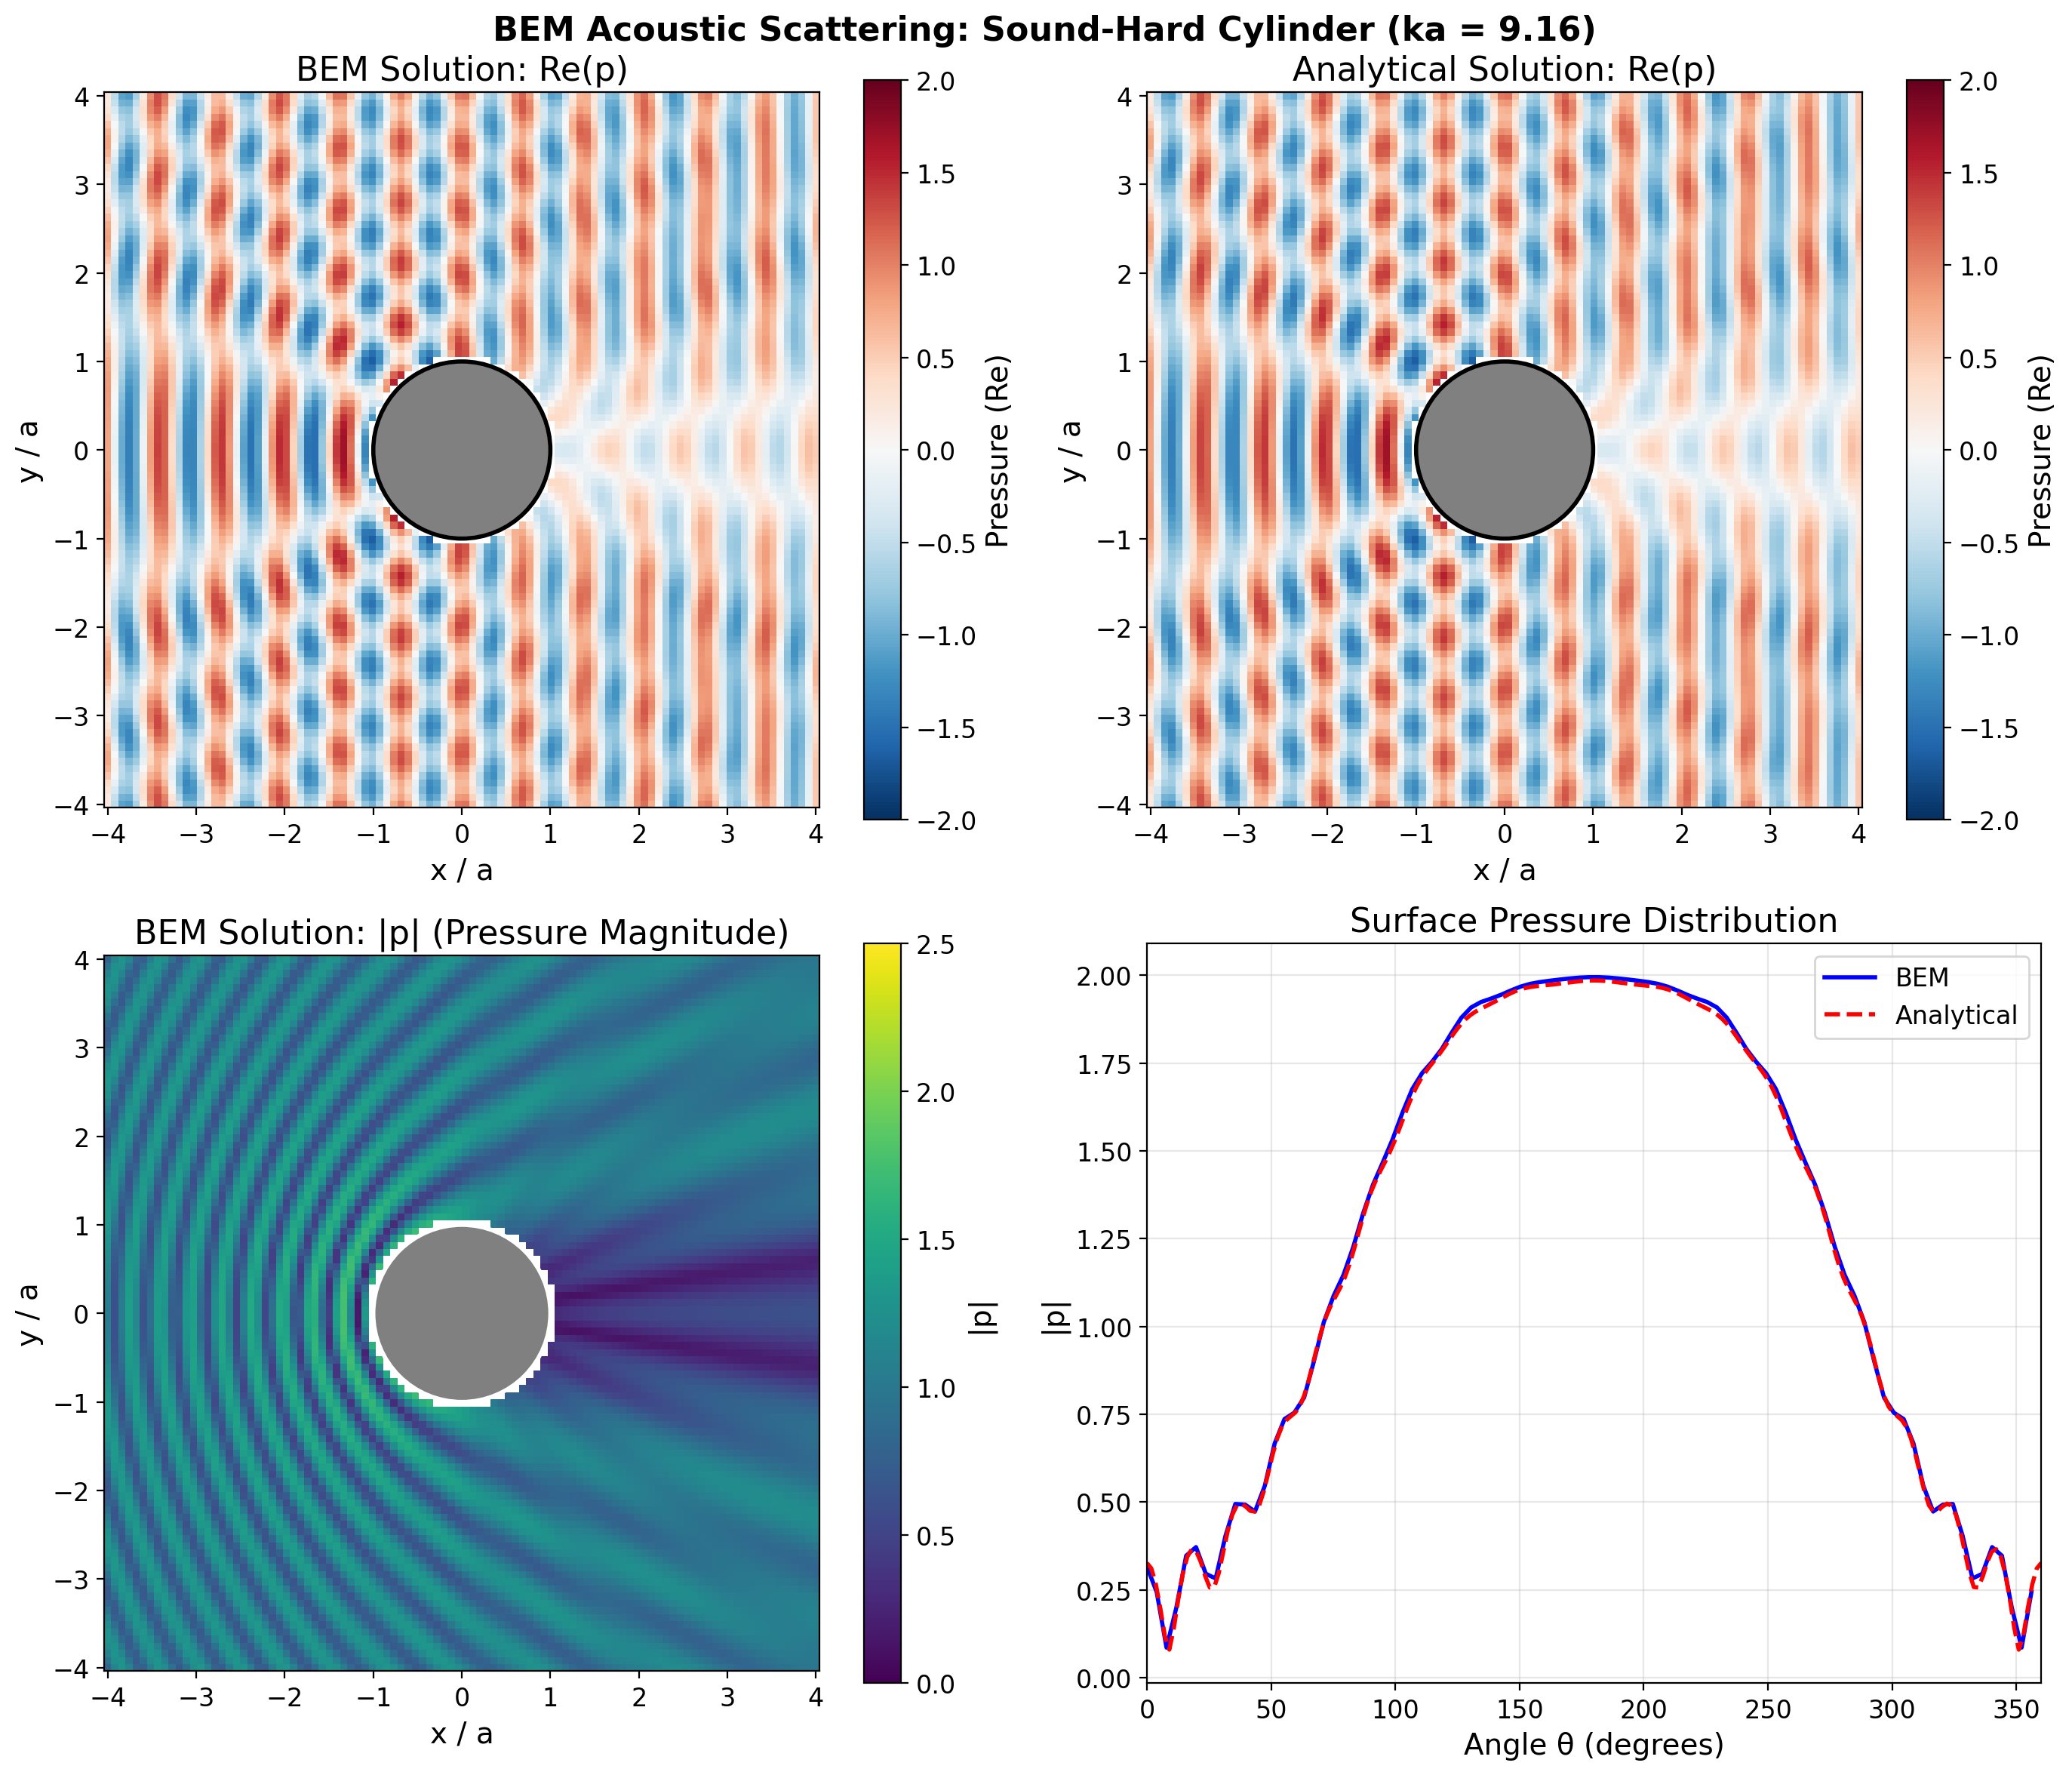

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Color scale limits
vmin, vmax = -2, 2

# Plot 1: BEM solution (real part)
ax1 = axes[0, 0]
im1 = ax1.pcolormesh(X, Y, np.real(p_total), shading='auto', 
                      cmap='RdBu_r', vmin=vmin, vmax=vmax)
circle1 = plt.Circle((0, 0), radius, fill=True, color='gray', ec='black', lw=2)
ax1.add_patch(circle1)
ax1.set_aspect('equal')
ax1.set_xlabel('x / a')
ax1.set_ylabel('y / a')
ax1.set_title('BEM Solution: Re(p)')
plt.colorbar(im1, ax=ax1, label='Pressure (Re)')

# Plot 2: Analytical solution (real part)
ax2 = axes[0, 1]
im2 = ax2.pcolormesh(X, Y, np.real(p_analytical), shading='auto',
                      cmap='RdBu_r', vmin=vmin, vmax=vmax)
circle2 = plt.Circle((0, 0), radius, fill=True, color='gray', ec='black', lw=2)
ax2.add_patch(circle2)
ax2.set_aspect('equal')
ax2.set_xlabel('x / a')
ax2.set_ylabel('y / a')
ax2.set_title('Analytical Solution: Re(p)')
plt.colorbar(im2, ax=ax2, label='Pressure (Re)')

# Plot 3: Pressure magnitude |p|
ax3 = axes[1, 0]
im3 = ax3.pcolormesh(X, Y, np.abs(p_total), shading='auto',
                      cmap='viridis', vmin=0, vmax=2.5)
circle3 = plt.Circle((0, 0), radius, fill=True, color='gray', ec='white', lw=2)
ax3.add_patch(circle3)
ax3.set_aspect('equal')
ax3.set_xlabel('x / a')
ax3.set_ylabel('y / a')
ax3.set_title('BEM Solution: |p| (Pressure Magnitude)')
plt.colorbar(im3, ax=ax3, label='|p|')

# Plot 4: Surface pressure comparison
ax4 = axes[1, 1]
theta_boundary = np.linspace(0, 2*np.pi, N_elements, endpoint=False)

# BEM surface pressure
ax4.plot(np.degrees(theta_boundary), np.abs(p_surface), 'b-', 
         linewidth=2, label='BEM')

# Analytical surface pressure
theta_fine = np.linspace(0, 2*np.pi, 200)
p_surface_analytical = analytical_total_field(radius * np.ones_like(theta_fine), 
                                               theta_fine, k, radius)
ax4.plot(np.degrees(theta_fine), np.abs(p_surface_analytical), 'r--',
         linewidth=2, label='Analytical')

ax4.set_xlabel('Angle θ (degrees)')
ax4.set_ylabel('|p|')
ax4.set_title('Surface Pressure Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0, 360])

plt.suptitle(f'BEM Acoustic Scattering: Sound-Hard Cylinder (ka = {ka:.2f})', 
             fontsize=16, fontweight='bold')
plt.tight_layout()

# Save the figure
plt.savefig('boundary_element_method_acoustics_analysis.png', dpi=150, bbox_inches='tight')
print("Figure saved to plot.png")

plt.show()

## Error Analysis

In [8]:
# Compare BEM vs analytical at selected radial distances
theta_test = np.linspace(0, 2*np.pi, 100)
radii_test = [1.5, 2.0, 3.0]

print("Error Analysis: BEM vs Analytical Solution")
print("=" * 50)

for r_test in radii_test:
    # Evaluation points at this radius
    test_points = np.column_stack([r_test * np.cos(theta_test),
                                    r_test * np.sin(theta_test)])
    
    # BEM solution
    p_bem_test = bem.compute_total_field(p_surface, test_points, incident_direction)
    
    # Analytical solution
    p_ana_test = analytical_total_field(r_test * np.ones_like(theta_test),
                                         theta_test, k, radius)
    
    # Compute errors
    abs_error = np.abs(p_bem_test - p_ana_test)
    rel_error = abs_error / np.abs(p_ana_test)
    
    print(f"\nRadius r = {r_test}a:")
    print(f"  Max absolute error: {np.max(abs_error):.6f}")
    print(f"  Mean absolute error: {np.mean(abs_error):.6f}")
    print(f"  Max relative error: {np.max(rel_error)*100:.4f}%")
    print(f"  Mean relative error: {np.mean(rel_error)*100:.4f}%")

Error Analysis: BEM vs Analytical Solution

Radius r = 1.5a:
  Max absolute error: 0.014165
  Mean absolute error: 0.006640
  Max relative error: 8.4123%
  Mean relative error: 1.1820%

Radius r = 2.0a:
  Max absolute error: 0.016332
  Mean absolute error: 0.005462
  Max relative error: 7.0228%
  Mean relative error: 0.9036%

Radius r = 3.0a:
  Max absolute error: 0.015368
  Mean absolute error: 0.004285
  Max relative error: 5.1164%
  Mean relative error: 0.6244%


## Physical Interpretation

The results demonstrate several key acoustic phenomena:

1. **Shadow Region**: Behind the cylinder (positive x), we observe a reduction in pressure amplitude - this is the acoustic shadow created by the obstacle.

2. **Bright Spot**: On the illuminated side (negative x), constructive interference between incident and reflected waves creates higher pressure amplitudes.

3. **Diffraction Pattern**: The wave pattern around the cylinder shows characteristic diffraction fringes, indicating that acoustic waves bend around the obstacle.

4. **Standing Wave Pattern**: In front of the cylinder, interference between incident and reflected waves creates a standing wave pattern.

## Conclusions

This notebook demonstrated the Boundary Element Method for 2D acoustic scattering:

- The BEM reduces a 2D domain problem to a 1D boundary problem
- The Kirchhoff-Helmholtz integral equation provides an exact representation
- Numerical discretization with constant elements yields accurate results
- Comparison with analytical series solution validates the implementation
- The method naturally handles the radiation condition for exterior problems

### Advantages of BEM for Acoustics:
- No domain truncation or absorbing boundary conditions needed
- Reduced computational cost for exterior problems
- High accuracy for smooth geometries

### Limitations:
- Dense system matrices (O(N²) storage and O(N³) solution cost)
- Singular integrals require special treatment
- Non-uniqueness at certain frequencies (requires CHIEF or Burton-Miller formulation)